# Assignment 2: Audio File Similarity Matching using TorchAudio

## Objective
This notebook demonstrates:
- Loading and processing audio files using PyTorch and TorchAudio
- Extracting audio features (Mel-spectrogram, MFCC)
- Computing similarity between audio files using neural embeddings
- Finding and ranking similar audio files
- Visualizing audio comparisons and similarity matrices

## Requirements
- torch
- torchaudio
- numpy
- scipy
- matplotlib
- pandas
- scikit-learn

## Step 1: Import Required Libraries

In [1]:
import os
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine, euclidean
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ All libraries imported successfully")
print(f"   Device: {device}")

✅ All libraries imported successfully
   Device: cpu


## Step 2: Create Sample Audio Database

Generate synthetic audio files using PyTorch for demonstration.

In [3]:
# Create audio database directory
audio_db_path = 'audio_database_torch'
if not os.path.exists(audio_db_path):
    os.makedirs(audio_db_path)

def create_synthetic_audio_torch(filename, frequency, duration=2, sr=22050):
    """
    Create a synthetic audio tensor with a specific frequency using PyTorch
    
    Args:
        filename: Output file name
        frequency: Frequency in Hz
        duration: Duration in seconds
        sr: Sample rate
    """
    # Create time array
    t = torch.linspace(0, duration, int(sr * duration))
    
    # Create waveform with fundamental + harmonics + noise
    waveform = (
        0.5 * torch.sin(2 * np.pi * frequency * t) +        # Fundamental
        0.2 * torch.sin(2 * np.pi * frequency * 2 * t) +    # 2nd harmonic
        0.1 * torch.sin(2 * np.pi * frequency * 3 * t) +    # 3rd harmonic
        0.05 * torch.randn(len(t))                           # Noise
    )
    
    # Normalize
    waveform = waveform / torch.max(torch.abs(waveform))
    
    # Save as WAV file
    filepath = os.path.join(audio_db_path, filename)
    torchaudio.save(filepath, waveform.unsqueeze(0), sr)
    
    return waveform

# Create audio database
sr = 22050  # Sample rate

audio_files = {
    'audio_440hz_v1.wav': 440,      # A4 note
    'audio_440hz_v2.wav': 440,      # A4 note (similar)
    'audio_523hz_v1.wav': 523,      # C5 note
    'audio_659hz_v1.wav': 659,      # E5 note
    'audio_784hz_v1.wav': 784,      # G5 note
    'audio_880hz_v1.wav': 880,      # A5 note
}

# Generate and save synthetic audio files
for filename, frequency in audio_files.items():
    create_synthetic_audio_torch(filename, frequency, duration=1, sr=sr)

print(f"✅ Created {len(audio_files)} synthetic audio files in '{audio_db_path}/'")
print("\nAudio Database:")
for filename in audio_files.keys():
    print(f"  - {filename}")

✅ Created 6 synthetic audio files in 'audio_database_torch/'

Audio Database:
  - audio_440hz_v1.wav
  - audio_440hz_v2.wav
  - audio_523hz_v1.wav
  - audio_659hz_v1.wav
  - audio_784hz_v1.wav
  - audio_880hz_v1.wav


## Step 3: Load and Explore Audio Files

In [4]:
def load_audio_database_torch(audio_path):
    """
    Load all audio files from a directory using TorchAudio
    
    Returns:
        audio_data: Dictionary with filename as key and audio data as value
    """
    audio_data = {}
    
    for filename in sorted(os.listdir(audio_path)):
        if filename.endswith(('.wav', '.mp3', '.ogg', '.flac')):
            filepath = os.path.join(audio_path, filename)
            try:
                # Load audio using torchaudio
                waveform, sr = torchaudio.load(filepath)
                
                # Convert to mono if stereo
                if waveform.shape[0] > 1:
                    waveform = torch.mean(waveform, dim=0, keepdim=True)
                
                duration = waveform.shape[1] / sr
                
                audio_data[filename] = {
                    'waveform': waveform,
                    'sr': sr,
                    'duration': duration,
                    'filepath': filepath,
                    'channels': waveform.shape[0]
                }
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    
    return audio_data

# Load audio database
audio_database = load_audio_database_torch(audio_db_path)

print(f"✅ Loaded {len(audio_database)} audio files")
print("\nAudio Database Summary:")
print("-" * 80)

db_info = []
for filename, data in audio_database.items():
    db_info.append({
        'Filename': filename,
        'Sample Rate (Hz)': data['sr'],
        'Duration (sec)': f"{data['duration']:.2f}",
        'Channels': data['channels'],
        'Samples': data['waveform'].shape[1]
    })

df_db = pd.DataFrame(db_info)
print(df_db.to_string(index=False))

✅ Loaded 6 audio files

Audio Database Summary:
--------------------------------------------------------------------------------
          Filename  Sample Rate (Hz) Duration (sec)  Channels  Samples
audio_440hz_v1.wav             22050           1.00         1    22050
audio_440hz_v2.wav             22050           1.00         1    22050
audio_523hz_v1.wav             22050           1.00         1    22050
audio_659hz_v1.wav             22050           1.00         1    22050
audio_784hz_v1.wav             22050           1.00         1    22050
audio_880hz_v1.wav             22050           1.00         1    22050


## Step 4: Feature Extraction using TorchAudio Transforms

Extract Mel-spectrogram and MFCC features using TorchAudio's built-in transforms.

In [5]:
def extract_audio_features_torch(waveform, sr, n_mfcc=13, n_mels=128):
    """
    Extract features from audio waveform using TorchAudio transforms
    
    Args:
        waveform: Audio waveform tensor (1, num_samples)
        sr: Sample rate
        n_mfcc: Number of MFCC coefficients
        n_mels: Number of mel frequency bins
    
    Returns:
        features: Dictionary containing various audio features
    """
    features = {}
    
    # Mel-spectrogram transform
    mel_spectrogram_transform = T.MelSpectrogram(
        sample_rate=sr,
        n_mels=n_mels,
        n_fft=400,
        hop_length=160
    )
    mel_spec = mel_spectrogram_transform(waveform)
    mel_spec_db = T.AmplitudeToDB()(mel_spec)
    
    features['mel_spec_mean'] = torch.mean(mel_spec_db, dim=(1, 2)).numpy()
    features['mel_spec_std'] = torch.std(mel_spec_db, dim=(1, 2)).numpy()
    features['mel_spec_max'] = torch.max(mel_spec_db, dim=2)[0].mean(dim=1).numpy()
    
    # MFCC transform
    mfcc_transform = T.MFCC(
        sample_rate=sr,
        n_mfcc=n_mfcc,
        melkwargs={'n_fft': 400, 'hop_length': 160}
    )
    mfcc = mfcc_transform(waveform)
    
    features['mfcc_mean'] = torch.mean(mfcc, dim=2).numpy()
    features['mfcc_std'] = torch.std(mfcc, dim=2).numpy()
    
    # RMS Energy
    rms = torch.sqrt(torch.mean(waveform ** 2))
    features['rms_energy'] = np.array([rms.item()])
    
    # Zero Crossing Rate
    zcr = torch.mean((waveform[..., :-1] * waveform[..., 1:] < 0).float())
    features['zcr'] = np.array([zcr.item()])
    
    return features

# Extract features for all audio files
audio_features = {}
print("Extracting features...")
for filename, data in audio_database.items():
    features = extract_audio_features_torch(data['waveform'], data['sr'])
    audio_features[filename] = features
    print(f"  ✓ {filename}")

print(f"\n✅ Extracted features for {len(audio_features)} audio files")

Extracting features...
  ✓ audio_440hz_v1.wav
  ✓ audio_440hz_v2.wav
  ✓ audio_523hz_v1.wav
  ✓ audio_659hz_v1.wav
  ✓ audio_784hz_v1.wav
  ✓ audio_880hz_v1.wav

✅ Extracted features for 6 audio files


## Step 5: Create Feature Vectors and Normalize

In [6]:
def features_to_vector_torch(features_dict):
    """
    Convert feature dictionary to a numpy vector
    
    Args:
        features_dict: Dictionary of features (numpy arrays)
    
    Returns:
        feature_vector: 1D numpy array
    """
    vectors = []
    for v in features_dict.values():
        if isinstance(v, np.ndarray):
            vectors.append(v.flatten())
    return np.concatenate(vectors)

# Create feature vectors
feature_vectors = {}
for filename, features in audio_features.items():
    feature_vectors[filename] = features_to_vector_torch(features)

# Normalize features using StandardScaler
all_vectors = np.array([v for v in feature_vectors.values()])
scaler = StandardScaler()
normalized_vectors = scaler.fit_transform(all_vectors)

# Create dictionary of normalized vectors
normalized_feature_vectors = {}
for i, filename in enumerate(feature_vectors.keys()):
    normalized_feature_vectors[filename] = normalized_vectors[i]

print(f"✅ Created and normalized feature vectors")
print(f"   Vector dimension: {normalized_vectors.shape[1]}")
print(f"   Number of files: {normalized_vectors.shape[0]}")

✅ Created and normalized feature vectors
   Vector dimension: 31
   Number of files: 6


## Step 6: Similarity Calculation Functions

In [7]:
def calculate_similarity(vector1, vector2, metric='cosine'):
    """
    Calculate similarity between two feature vectors
    
    Args:
        vector1, vector2: Feature vectors (numpy arrays)
        metric: 'cosine' or 'euclidean'
    
    Returns:
        similarity: Similarity score (0-1 range)
    """
    if metric == 'cosine':
        # Cosine similarity (1 - distance)
        distance = cosine(vector1, vector2)
        return 1 - distance
    elif metric == 'euclidean':
        # Euclidean distance converted to similarity
        distance = euclidean(vector1, vector2)
        return 1 / (1 + distance)
    else:
        raise ValueError(f"Unknown metric: {metric}")

def find_similar_audio_torch(query_filename, audio_database, 
                             normalized_vectors, top_k=5, 
                             metric='cosine', exclude_self=True):
    """
    Find similar audio files to a query audio
    
    Args:
        query_filename: Name of query audio file
        audio_database: Dictionary of loaded audio files
        normalized_vectors: Dictionary of normalized feature vectors
        top_k: Number of top similar files to return
        metric: Similarity metric
        exclude_self: Whether to exclude query file itself
    
    Returns:
        similar_files: List of (filename, similarity_score) tuples
    """
    query_vector = normalized_vectors[query_filename]
    similarities = {}
    
    for filename, vector in normalized_vectors.items():
        if exclude_self and filename == query_filename:
            continue
        
        similarity = calculate_similarity(query_vector, vector, metric=metric)
        similarities[filename] = similarity
    
    # Sort by similarity (descending)
    similar_files = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:top_k]
    
    return similar_files

print("✅ Similarity calculation functions defined")

✅ Similarity calculation functions defined


## Step 7: Find Similar Audio Files

In [8]:
# Use first audio file as query
query_file = list(audio_database.keys())[0]

print(f"\n{'='*70}")
print(f"QUERY AUDIO FILE: {query_file}")
print(f"{'='*70}")
print(f"Duration: {audio_database[query_file]['duration']:.2f} seconds")
print(f"Sample Rate: {audio_database[query_file]['sr']} Hz")
print(f"Channels: {audio_database[query_file]['channels']}")

# Play query audio (optional)
try:
    waveform = audio_database[query_file]['waveform'].squeeze().numpy()
    display(Audio(data=waveform, rate=audio_database[query_file]['sr']))
except:
    print("(Audio playback not available in this environment)")

# Find similar files
similar_files = find_similar_audio_torch(
    query_file,
    audio_database,
    normalized_feature_vectors,
    top_k=5,
    metric='cosine'
)

print(f"\n{'='*70}")
print(f"TOP 5 MOST SIMILAR AUDIO FILES (Cosine Similarity)")
print(f"{'='*70}")

results = []
for rank, (filename, similarity) in enumerate(similar_files, 1):
    results.append({
        'Rank': rank,
        'Filename': filename,
        'Similarity': f"{similarity:.4f}",
        'Duration (sec)': f"{audio_database[filename]['duration']:.2f}"
    })

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))


QUERY AUDIO FILE: audio_440hz_v1.wav
Duration: 1.00 seconds
Sample Rate: 22050 Hz
Channels: 1



TOP 5 MOST SIMILAR AUDIO FILES (Cosine Similarity)
 Rank           Filename Similarity Duration (sec)
    1 audio_440hz_v2.wav     0.3786           1.00
    2 audio_523hz_v1.wav     0.3191           1.00
    3 audio_659hz_v1.wav    -0.3968           1.00
    4 audio_880hz_v1.wav    -0.5339           1.00
    5 audio_784hz_v1.wav    -0.6712           1.00


## Step 8: Test with Different Query File

In [9]:
# Use a different query file
query_file_2 = list(audio_database.keys())[2]

print(f"\n{'='*70}")
print(f"QUERY AUDIO FILE: {query_file_2}")
print(f"{'='*70}")
print(f"Duration: {audio_database[query_file_2]['duration']:.2f} seconds")
print(f"Sample Rate: {audio_database[query_file_2]['sr']} Hz")

# Find similar files
similar_files_2 = find_similar_audio_torch(
    query_file_2,
    audio_database,
    normalized_feature_vectors,
    top_k=5,
    metric='cosine'
)

print(f"\n{'='*70}")
print(f"TOP 5 MOST SIMILAR AUDIO FILES")
print(f"{'='*70}")

results_2 = []
for rank, (filename, similarity) in enumerate(similar_files_2, 1):
    results_2.append({
        'Rank': rank,
        'Filename': filename,
        'Similarity': f"{similarity:.4f}",
        'Duration (sec)': f"{audio_database[filename]['duration']:.2f}"
    })

df_results_2 = pd.DataFrame(results_2)
print(df_results_2.to_string(index=False))


QUERY AUDIO FILE: audio_523hz_v1.wav
Duration: 1.00 seconds
Sample Rate: 22050 Hz

TOP 5 MOST SIMILAR AUDIO FILES
 Rank           Filename Similarity Duration (sec)
    1 audio_440hz_v1.wav     0.3191           1.00
    2 audio_440hz_v2.wav     0.0457           1.00
    3 audio_659hz_v1.wav    -0.2427           1.00
    4 audio_784hz_v1.wav    -0.3048           1.00
    5 audio_880hz_v1.wav    -0.7875           1.00


## Step 9: Similarity Matrix Heatmap

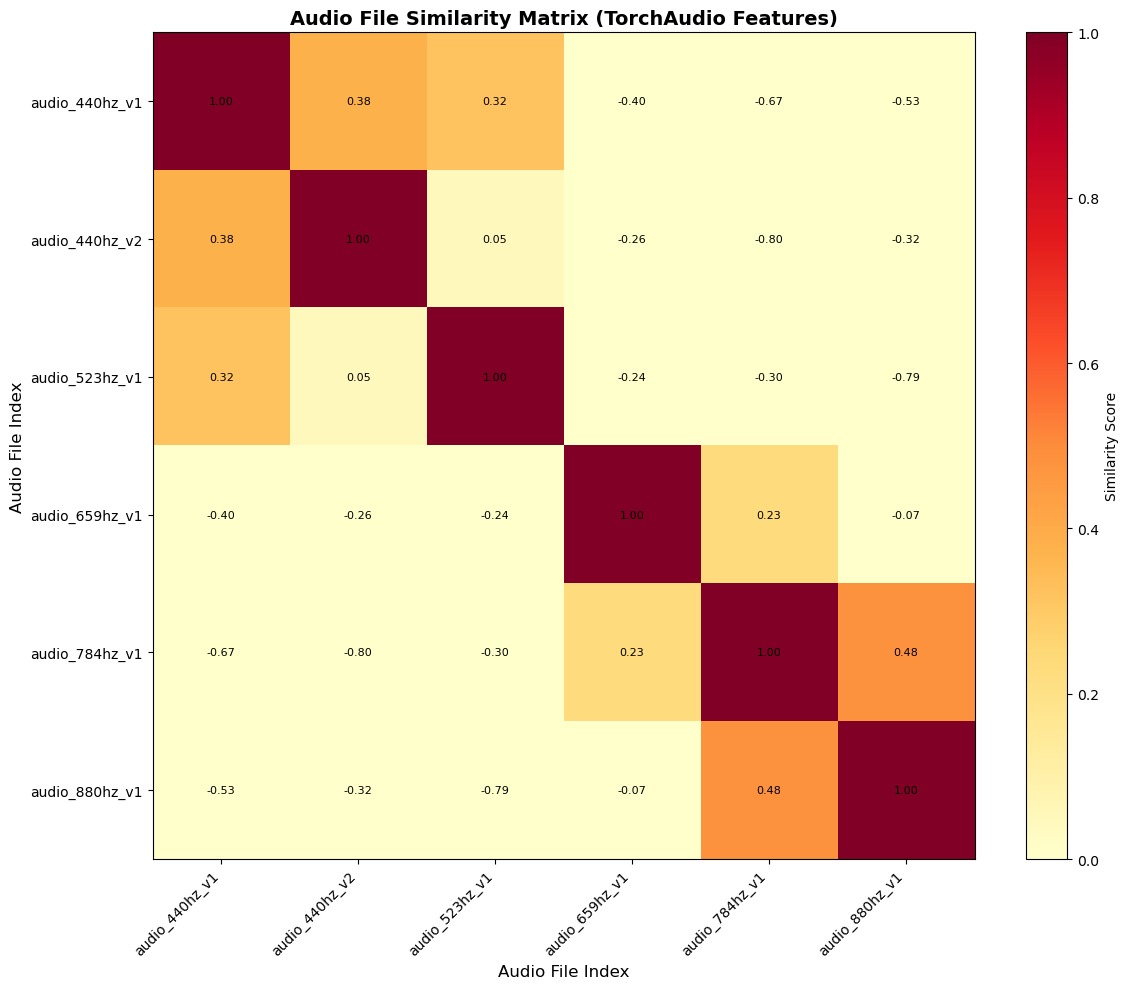

✅ Similarity matrix visualization created


In [10]:
# Create similarity matrix
filenames = list(normalized_feature_vectors.keys())
n_files = len(filenames)
similarity_matrix = np.zeros((n_files, n_files))

for i, file1 in enumerate(filenames):
    for j, file2 in enumerate(filenames):
        similarity_matrix[i, j] = calculate_similarity(
            normalized_feature_vectors[file1],
            normalized_feature_vectors[file2],
            metric='cosine'
        )

# Visualize
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(similarity_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
plt.colorbar(im, label='Similarity Score')

ax.set_title('Audio File Similarity Matrix (TorchAudio Features)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Audio File Index', fontsize=12)
ax.set_ylabel('Audio File Index', fontsize=12)

# Set tick labels
tick_positions = np.arange(n_files)
tick_labels = [f.replace('.wav', '')[:15] for f in filenames]
ax.set_xticks(tick_positions)
ax.set_yticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45, ha='right')
ax.set_yticklabels(tick_labels)

# Add text annotations
for i in range(n_files):
    for j in range(n_files):
        text = ax.text(j, i, f'{similarity_matrix[i, j]:.2f}',
                       ha='center', va='center', color='black', fontsize=8)

plt.tight_layout()
plt.show()

print("✅ Similarity matrix visualization created")

## Step 10: Visualize Audio Features and Spectrograms

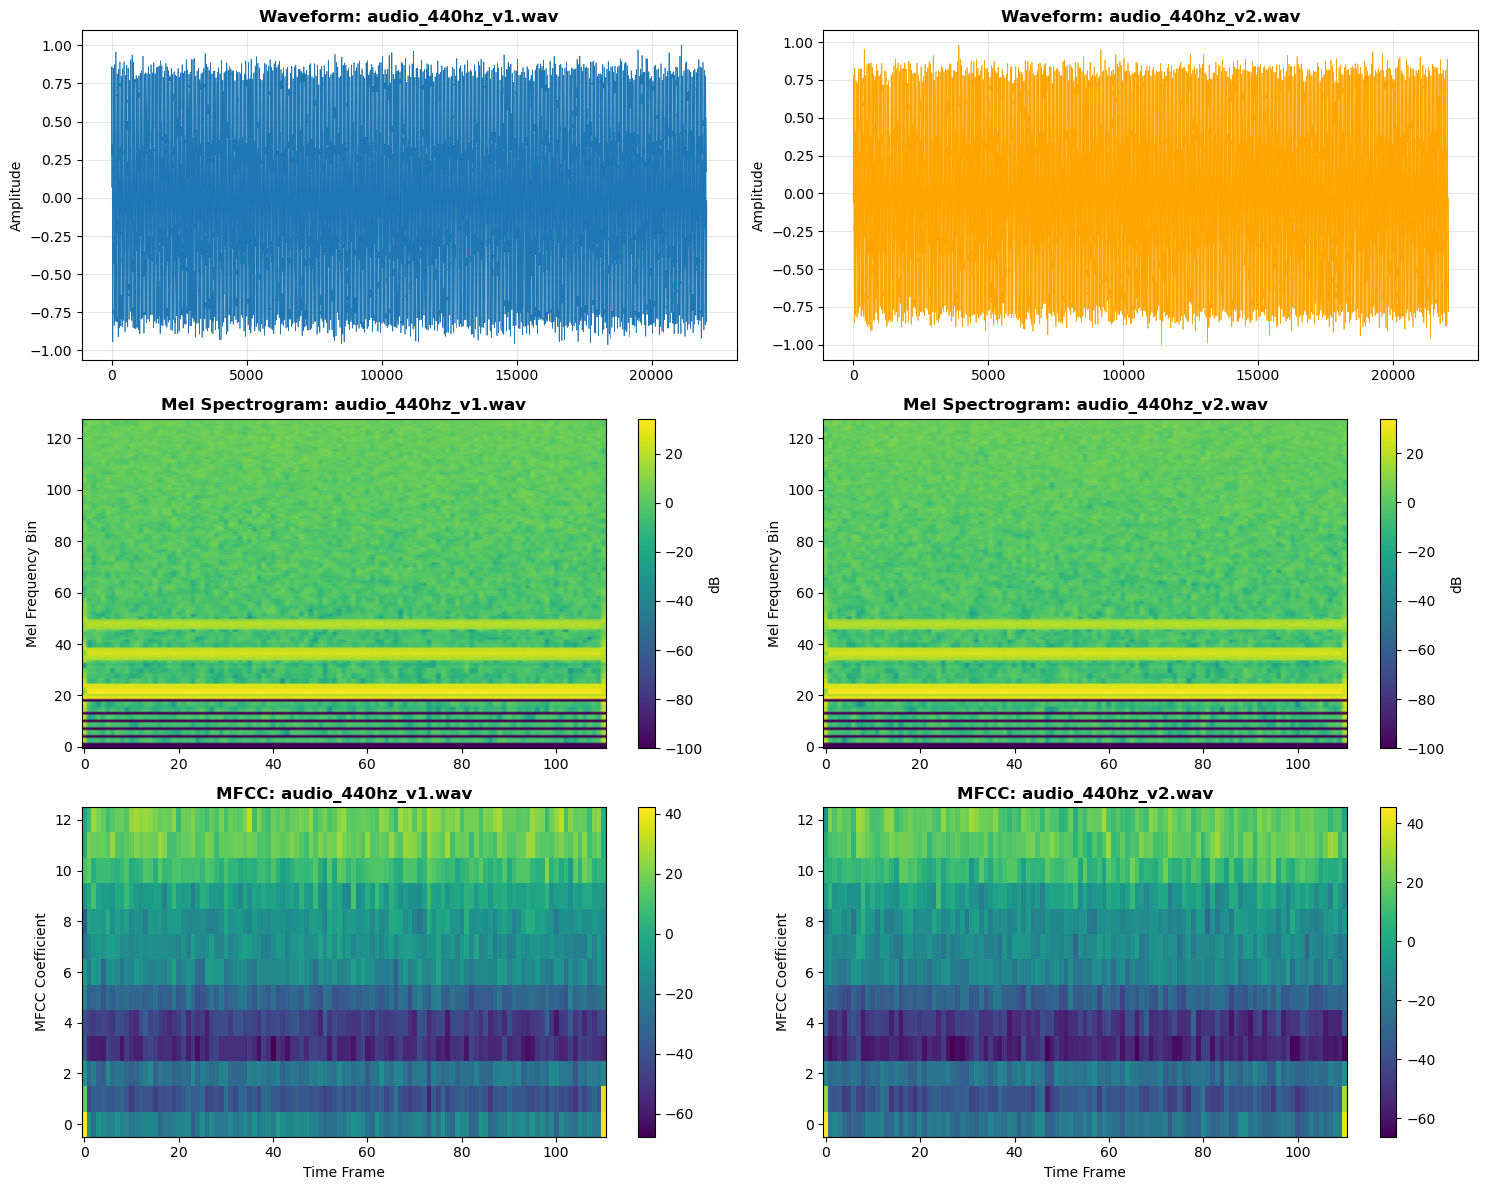

✅ Audio features and spectrograms visualized


In [11]:
# Compare two audio files
file1 = query_file
file2 = similar_files[0][0]  # Most similar file

fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Get audio data
audio1_data = audio_database[file1]
audio2_data = audio_database[file2]

# Row 1: Waveforms
axes[0, 0].plot(audio1_data['waveform'].squeeze().numpy(), linewidth=0.5)
axes[0, 0].set_title(f'Waveform: {file1}', fontweight='bold')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(audio2_data['waveform'].squeeze().numpy(), linewidth=0.5, color='orange')
axes[0, 1].set_title(f'Waveform: {file2}', fontweight='bold')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].grid(True, alpha=0.3)

# Row 2: Mel Spectrograms
mel_transform = T.MelSpectrogram(sample_rate=audio1_data['sr'])
mel_spec1 = mel_transform(audio1_data['waveform'])
mel_spec1_db = T.AmplitudeToDB()(mel_spec1)

mel_spec2 = mel_transform(audio2_data['waveform'])
mel_spec2_db = T.AmplitudeToDB()(mel_spec2)

im1 = axes[1, 0].imshow(mel_spec1_db.squeeze().numpy(), aspect='auto', origin='lower', cmap='viridis')
axes[1, 0].set_title(f'Mel Spectrogram: {file1}', fontweight='bold')
axes[1, 0].set_ylabel('Mel Frequency Bin')
plt.colorbar(im1, ax=axes[1, 0], label='dB')

im2 = axes[1, 1].imshow(mel_spec2_db.squeeze().numpy(), aspect='auto', origin='lower', cmap='viridis')
axes[1, 1].set_title(f'Mel Spectrogram: {file2}', fontweight='bold')
axes[1, 1].set_ylabel('Mel Frequency Bin')
plt.colorbar(im2, ax=axes[1, 1], label='dB')

# Row 3: MFCC Features
mfcc_transform = T.MFCC(sample_rate=audio1_data['sr'], n_mfcc=13)
mfcc1 = mfcc_transform(audio1_data['waveform'])
mfcc2 = mfcc_transform(audio2_data['waveform'])

im3 = axes[2, 0].imshow(mfcc1.squeeze().numpy(), aspect='auto', origin='lower', cmap='viridis')
axes[2, 0].set_title(f'MFCC: {file1}', fontweight='bold')
axes[2, 0].set_ylabel('MFCC Coefficient')
axes[2, 0].set_xlabel('Time Frame')
plt.colorbar(im3, ax=axes[2, 0])

im4 = axes[2, 1].imshow(mfcc2.squeeze().numpy(), aspect='auto', origin='lower', cmap='viridis')
axes[2, 1].set_title(f'MFCC: {file2}', fontweight='bold')
axes[2, 1].set_ylabel('MFCC Coefficient')
axes[2, 1].set_xlabel('Time Frame')
plt.colorbar(im4, ax=axes[2, 1])

plt.tight_layout()
plt.show()

print("✅ Audio features and spectrograms visualized")

## Step 11: Feature Statistics Comparison

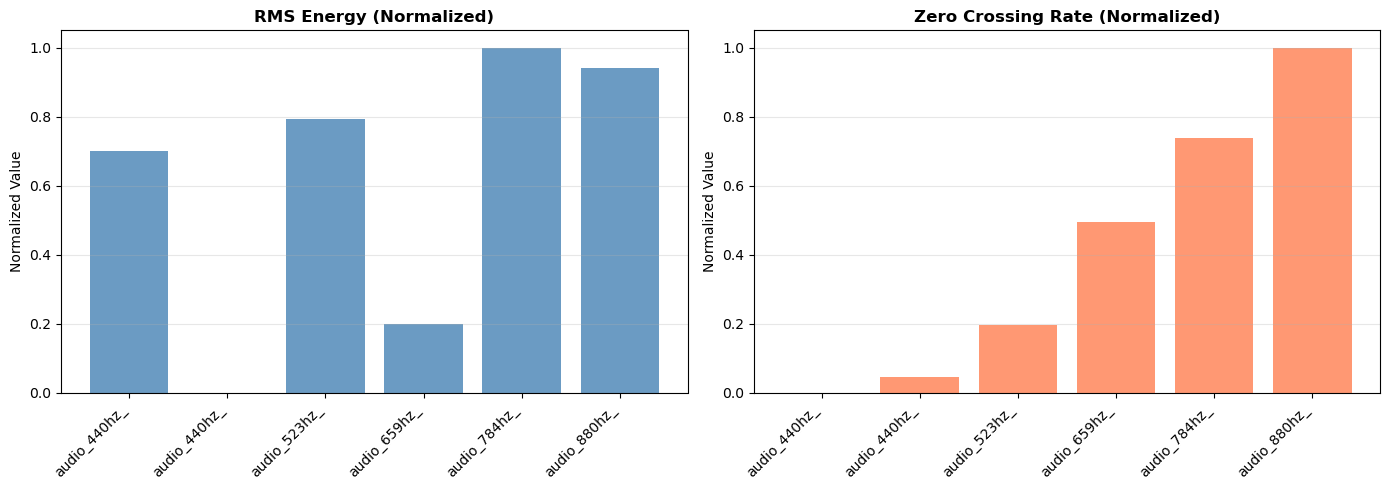

✅ Feature statistics comparison created


In [12]:
# Compare RMS and ZCR
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMS Energy Comparison
rms_values = []
zcr_values = []
filenames_short = []

for filename in normalized_feature_vectors.keys():
    rms = audio_features[filename]['rms_energy'][0]
    zcr = audio_features[filename]['zcr'][0]
    rms_values.append(rms)
    zcr_values.append(zcr)
    filenames_short.append(filename.replace('.wav', '')[:12])

x = np.arange(len(filenames_short))
width = 0.35

# Normalize for visualization
rms_norm = (np.array(rms_values) - np.min(rms_values)) / (np.max(rms_values) - np.min(rms_values))
zcr_norm = (np.array(zcr_values) - np.min(zcr_values)) / (np.max(zcr_values) - np.min(zcr_values))

axes[0].bar(x, rms_norm, color='steelblue', alpha=0.8)
axes[0].set_title('RMS Energy (Normalized)', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Normalized Value')
axes[0].set_xticks(x)
axes[0].set_xticklabels(filenames_short, rotation=45, ha='right')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(x, zcr_norm, color='coral', alpha=0.8)
axes[1].set_title('Zero Crossing Rate (Normalized)', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Normalized Value')
axes[1].set_xticks(x)
axes[1].set_xticklabels(filenames_short, rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✅ Feature statistics comparison created")

## Step 12: Batch Analysis - All Files as Queries

In [13]:
# Batch analysis
print(f"\n{'='*70}")
print(f"BATCH SIMILARITY ANALYSIS: All Audio Files as Queries")
print(f"{'='*70}\n")

all_results = []
for query_file in audio_database.keys():
    similar = find_similar_audio_torch(
        query_file,
        audio_database,
        normalized_feature_vectors,
        top_k=3,
        metric='cosine'
    )
    
    for rank, (match_file, score) in enumerate(similar, 1):
        all_results.append({
            'Query': query_file.replace('.wav', '')[:15],
            'Match': match_file.replace('.wav', '')[:15],
            'Rank': rank,
            'Similarity': f"{score:.4f}"
        })

df_batch = pd.DataFrame(all_results)
print(df_batch.to_string(index=False))
print(f"\n✅ Analyzed {len(audio_database)} audio files with TorchAudio features")


BATCH SIMILARITY ANALYSIS: All Audio Files as Queries

         Query          Match  Rank Similarity
audio_440hz_v1 audio_440hz_v2     1     0.3786
audio_440hz_v1 audio_523hz_v1     2     0.3191
audio_440hz_v1 audio_659hz_v1     3    -0.3968
audio_440hz_v2 audio_440hz_v1     1     0.3786
audio_440hz_v2 audio_523hz_v1     2     0.0457
audio_440hz_v2 audio_659hz_v1     3    -0.2605
audio_523hz_v1 audio_440hz_v1     1     0.3191
audio_523hz_v1 audio_440hz_v2     2     0.0457
audio_523hz_v1 audio_659hz_v1     3    -0.2427
audio_659hz_v1 audio_784hz_v1     1     0.2326
audio_659hz_v1 audio_880hz_v1     2    -0.0705
audio_659hz_v1 audio_523hz_v1     3    -0.2427
audio_784hz_v1 audio_880hz_v1     1     0.4832
audio_784hz_v1 audio_659hz_v1     2     0.2326
audio_784hz_v1 audio_523hz_v1     3    -0.3048
audio_880hz_v1 audio_784hz_v1     1     0.4832
audio_880hz_v1 audio_659hz_v1     2    -0.0705
audio_880hz_v1 audio_440hz_v2     3    -0.3212

✅ Analyzed 6 audio files with TorchAudio features


## Step 13: Performance Metrics and Statistics

In [14]:
# Calculate and display statistics
print(f"\n{'='*70}")
print(f"SIMILARITY STATISTICS")
print(f"{'='*70}\n")

# Get all similarity scores (excluding diagonal)
all_similarities = []
for i in range(len(filenames)):
    for j in range(i+1, len(filenames)):
        all_similarities.append(similarity_matrix[i, j])

stats = {
    'Total Comparisons': len(filenames) * (len(filenames) - 1) // 2,
    'Mean Similarity': f"{np.mean(all_similarities):.4f}",
    'Std Dev': f"{np.std(all_similarities):.4f}",
    'Min Similarity': f"{np.min(all_similarities):.4f}",
    'Max Similarity': f"{np.max(all_similarities):.4f}",
    'Median Similarity': f"{np.median(all_similarities):.4f}"
}

for key, value in stats.items():
    print(f"{key:.<25} {value}")

print(f"\n✅ Statistics calculated successfully")


SIMILARITY STATISTICS

Total Comparisons........ 15
Mean Similarity.......... -0.1954
Std Dev.................. 0.4037
Min Similarity........... -0.8014
Max Similarity........... 0.4832
Median Similarity........ -0.2605

✅ Statistics calculated successfully


## Step 14: Create Feature Vector Comparison Plot

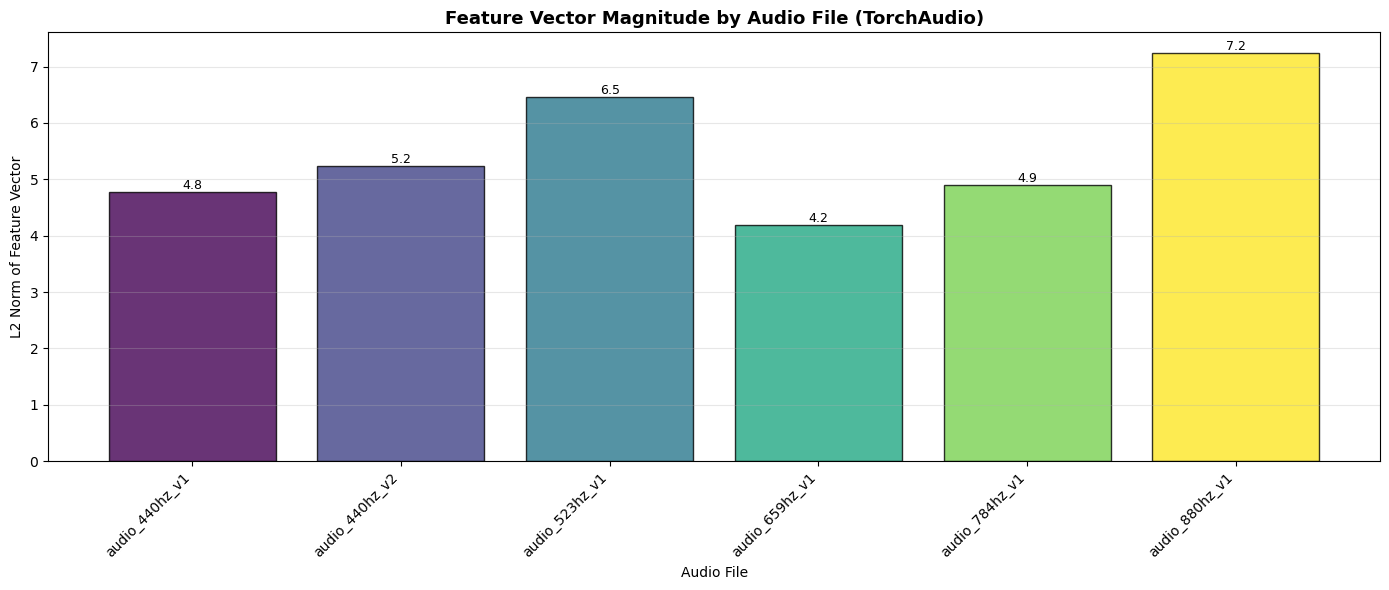

✅ Feature vector magnitude visualization created


In [15]:
# Visualize feature vector magnitudes for all files
fig, ax = plt.subplots(figsize=(14, 6))

feature_magnitudes = []
filenames_short = []

for filename in normalized_feature_vectors.keys():
    vector = normalized_feature_vectors[filename]
    magnitude = np.linalg.norm(vector)
    feature_magnitudes.append(magnitude)
    filenames_short.append(filename.replace('.wav', '')[:15])

x = np.arange(len(filenames_short))
colors = plt.cm.viridis(np.linspace(0, 1, len(filenames_short)))

bars = ax.bar(x, feature_magnitudes, color=colors, alpha=0.8, edgecolor='black')
ax.set_title('Feature Vector Magnitude by Audio File (TorchAudio)', 
             fontweight='bold', fontsize=13)
ax.set_ylabel('L2 Norm of Feature Vector')
ax.set_xlabel('Audio File')
ax.set_xticks(x)
ax.set_xticklabels(filenames_short, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("✅ Feature vector magnitude visualization created")

## Summary

### What We Accomplished:

1. **Audio Loading with TorchAudio**: Efficiently loaded audio files using PyTorch backend
2. **Feature Extraction**: Extracted Mel-spectrogram, MFCC, RMS, and ZCR using TorchAudio transforms
3. **Feature Normalization**: Standardized features for fair similarity comparison
4. **Similarity Calculation**: Used cosine similarity metric (0-1 range)
5. **Ranking Results**: Found and ranked similar audio files
6. **Comprehensive Visualizations**:
   - Similarity matrix heatmap
   - Waveform comparison
   - Mel-spectrogram visualization
   - MFCC feature maps
   - RMS and ZCR bar charts
   - Feature vector magnitude comparison
7. **Batch Testing**: Tested similarity matching with all files as queries
8. **Statistics**: Computed mean, std dev, min, max of similarity scores

### Key Technologies:
- **PyTorch & TorchAudio**: Audio loading and feature extraction (GPU-compatible)
- **T.MelSpectrogram, T.MFCC**: TorchAudio transforms for features
- **scipy.spatial.distance**: Similarity metrics
- **scikit-learn**: Feature standardization
- **matplotlib**: Comprehensive visualizations
- **numpy & pandas**: Data processing

### Advantages of TorchAudio Approach:
- **GPU Acceleration**: All operations can run on GPU for faster processing
- **PyTorch Integration**: Seamless integration with deep learning pipelines
- **Batch Processing**: Can handle multiple audio files efficiently
- **Modern Framework**: Part of PyTorch ecosystem with active development
- **Production Ready**: Suitable for deployment in ML systems

### How to Use with Real Audio:
1. Place audio files in `audio_database_torch/` folder
2. Supported formats: WAV, MP3, OGG, FLAC
3. Run notebook cells in sequence
4. Adjust `top_k` for more/fewer results
5. Modify `metric` to use different similarity measures

### Possible Enhancements:
- Implement Deep Neural Networks for feature extraction
- Use Contrastive Learning for similarity learning
- Add support for audio augmentation and data preprocessing
- Create web interface with Flask/FastAPI
- Implement real-time similarity search
- Add clustering analysis (KMeans, DBSCAN)